# Dataset hierarchical clustering

# Universidad Nacional Abierta y a Distancia - UNAD
# Curso: Análisis de datos

Este dataset contiene información de clientes de un mall. Las variables incluyen género, ingreso, puntaje de gasto, etc.

In [109]:
#Importar las librerias necesarias para el desarrollo de la actividad
import pandas as pd # Manejo y análisis de estructuras de datos
import numpy as np # Cálculo numérico y el análisis de datos
import seaborn as sns # Creación gráficos estadísticos
import matplotlib.pyplot as plt # Creación de gráficos en dos dimensiones
import plotly.graph_objs as go # Creación de gráficos en tres dimensiones
import plotly.express as px # Creación de gráficos en tres dimensiones
import plotly as py
import warnings
warnings.filterwarnings('ignore')

# librerías de para implementar modelo
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet
from sklearn.cluster import KMeans

# librerías de para evaluar el modelo
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [10]:
# Cargar datos
data = pd.read_csv ('./Mall_Customers.csv')

### 1. Realizar un análisis exploratorio de los datos para identificar relaciones entre variables, valores atípicos, tendencias, etc.

In [11]:
# Realizamos lectura de los Datos para el análisis exploratorio

data.head(10)

,ClienteID,Genero,Edad,Ingresos_Anuales,Puntuacion_Gasto
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [12]:
# Cantidad de registros (filas y columnas)
num_filas, num_columnas = data.shape

# Imprimir el número de filas y columnas
print("Número de filas:", num_filas)
print("Número de columnas:", num_columnas)

Número de filas: 200
Número de columnas: 5


In [13]:
# Eliminación de columna IDCliente
data=data.drop(['ClienteID'], axis=1)

In [14]:
# Descripción de los datos
data.describe()

,Edad,Ingresos_Anuales,Puntuacion_Gasto
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


<Axes: >

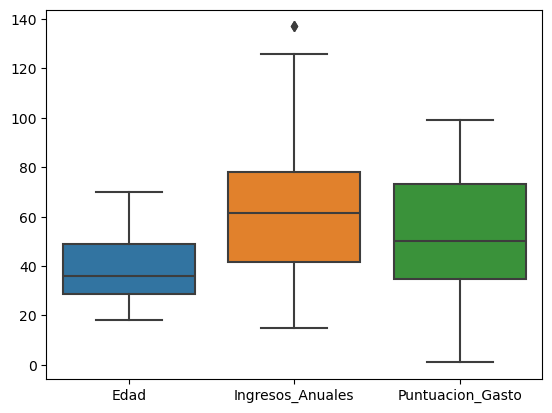

In [15]:
#Identificación de valores faltantes y atípicos mediante una grafica 

# Diagramas de caja para cada variable por cliente
sns.boxplot(data=data)

### 2. Preprocesar los datos limpiándolos, tratando valores faltantes y transformándolos según sea necesario.

In [16]:
# Los valores de 'Genero' son 'Male' y 'Female'.
# Se asigna 1 a 'Male' y 2 a 'Female' usando el método 'map' o 'replace'.

# Creación de un diccionario de mapeo para la codificación
genero_mapeo = {'Male': 1, 'Female': 2}

# Reemplazar la columna 'Genero' con valores numéricos utilizando el diccionario de mapeo
data['Genero'] = data['Genero'].map(genero_mapeo)

# Visualizar los primeros registros del DataFrame con la codificación numérica de 'Genero'
print(data.head())

   Genero  Edad  Ingresos_Anuales  Puntuacion_Gasto
0       1    19                15                39
1       1    21                15                81
2       2    20                16                 6
3       2    23                16                77
4       2    31                17                40


In [17]:
# Comprobando valores nulos
data.isnull().sum()*100/data.shape[0]

#Se logra determinar que en las variables no se encuentran varoles nulos.

Genero              0.0
Edad                0.0
Ingresos_Anuales    0.0
Puntuacion_Gasto    0.0
dtype: float64

In [18]:
# Lista de columnas númericas
columnas = ['Edad', 'Ingresos_Anuales', 'Puntuacion_Gasto']

for columna in columnas:
    # Calcular los cuartiles y el rango intercuartílico (IQR)
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcular los límites para identificar los valores atípicos
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificar los valores atípicos
    valores_atipicos = ((data[columna] < limite_inferior) | (data[columna] > limite_superior)).sum()
    
    # Imprimir los valores atípicos
    print(f"Datos atípicos de {columna} es: {valores_atipicos}")

Datos atípicos de Edad es: 0
Datos atípicos de Ingresos_Anuales es: 2
Datos atípicos de Puntuacion_Gasto es: 0


In [19]:
# Creación de un DataFrame para almacenar los datos filtrados
data_filtro = data.copy()

for columna in columnas:
    # Calcular los cuartiles y el rango intercuartílico (IQR)
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcular los límites para identificar los valores atípicos
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificar los valores atípicos
    valores_atipicos = data[(data[columna] < limite_inferior) | (data[columna] > limite_superior)][columna]
    
    # Filtrar los datos para eliminar los valores atípicos
    data_filtro = data_filtro[(data_filtro[columna] >= limite_inferior) & (data_filtro[columna] <= limite_superior)]

# Verificar el tamaño de los datos filtrados
print("Tamaño de los datos filtrados:")
print(data_filtro.shape)

Tamaño de los datos filtrados:
(198, 4)


In [20]:
for columna in columnas:
    # Calcular los cuartiles y el rango intercuartílico (IQR)
    Q1 = data_filtro[columna].quantile(0.25)
    Q3 = data_filtro[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcular los límites para identificar los valores atípicos
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificar los valores atípicos
    valores_atipicos = ((data_filtro[columna] < limite_inferior) | (data_filtro[columna] > limite_superior)).sum()
    
    # Imprimir los valores atípicos
    print(f"Datos atípicos de {columna} es: {valores_atipicos}")

Datos atípicos de Edad es: 0
Datos atípicos de Ingresos_Anuales es: 0
Datos atípicos de Puntuacion_Gasto es: 0


Genero
2    112
1     86
Name: count, dtype: int64

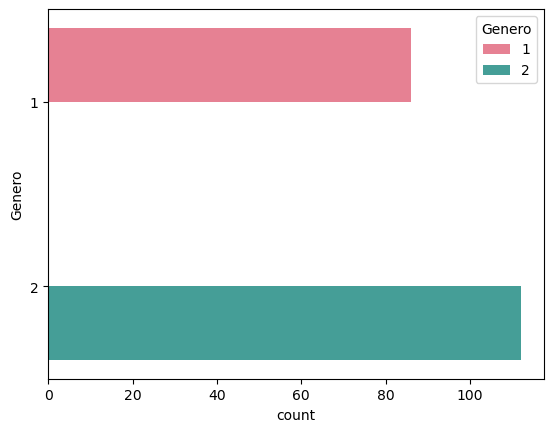

In [92]:
sns.countplot(y = 'Genero', data = data_filtro, palette="husl", hue = "Genero")
data_filtro["Genero"].value_counts()

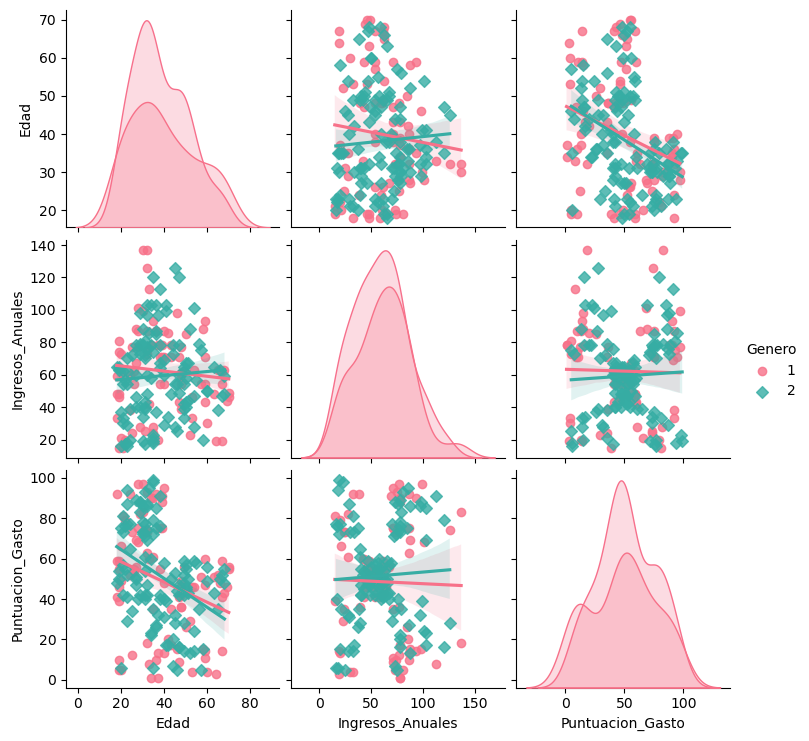

In [80]:
sns.pairplot(df, vars=["Edad", "Ingresos_Anuales", "Puntuacion_Gasto"],  kind ="reg", hue = "Genero", palette="husl", markers = ['o','D'])

### Análisis
- Dado que el género no es un valor numérico sino una columna con variables categórica, se reemplaza estos valores por medio del diccionario de mapeo para la codificación, donde a 'Male' se le asigna 1 y 2 a 'Female'.
- El género es usado únicamente para separar los datos y así poder diferenciar los valores de hombres y mujeres, pero las variables de interés son: Edad, Ingresos Anuales y Puntuación de Gastos.
- En el gráfico de pairplot se puede observar claramente la relación entre las diferentes variables que tenemos en nuestro conjunto de datos. En la proporción entre hombres y mujeres se puede observar que en el color rosa se puede encontrar mayor proporción que el verde, ya que hay más mujeres que hombre.


### Edad e ingresos anuales

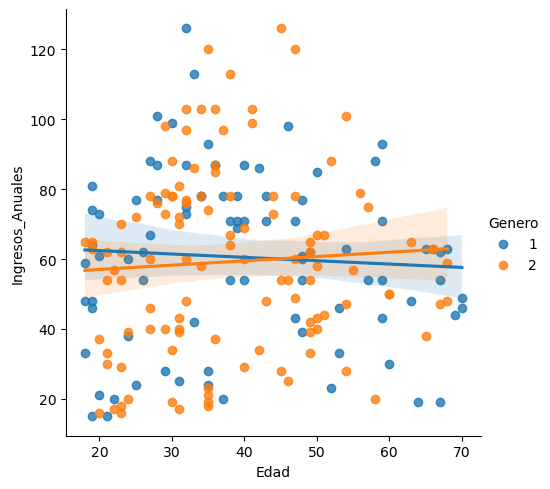

In [95]:
sns.lmplot(x = "Edad", y = "Ingresos_Anuales", data = data_filtro, hue = "Genero")

### Análisis
El gráfico muestra que las personas de entre 30 y 50 años tienden a ganar más dinero anualmente que aquellas que son menores de 30 o mayores de 50 años. Esto sugiere que las personas en este rango de edad pueden conseguir mejores trabajos debido a su mayor experiencia o preparación en comparación con los jóvenes o las personas mayores. Además, el gráfico revela que, al menos hasta los 50 años, los hombres suelen ganar un poco más de dinero que las mujeres.

### Edad y Puntuacion_Gasto

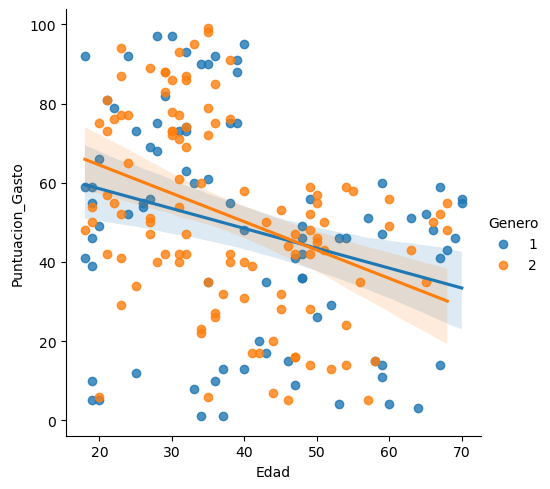

In [97]:
sns.lmplot(x = "Edad", y = "Puntuacion_Gasto", data = data_filtro, hue = "Genero")

### Análisis
En este gráfico se puede evidenciar y predecir que los jóvenes tienden a gastar mucho más que las personas mayores. Esto puede deberse a diversas razones, como el hecho de que los jóvenes suelen tener más tiempo libre que las personas mayores y una mayor predisposición a gastar en experiencias y productos de moda. Además, los centros comerciales suelen albergar tiendas y actividades dirigidas a los jóvenes, como tiendas de videojuegos, tecnología, ropa de moda y lugares de entretenimiento. También es probable que los jóvenes estén más influenciados por las tendencias y las redes sociales, lo que puede motivarles a gastar más en productos populares.

### Ingresos_Anuales y Puntuacion_Gasto

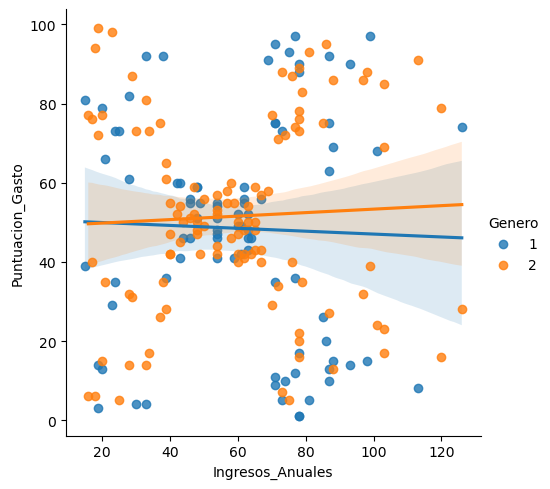

In [98]:
sns.lmplot(x = "Ingresos_Anuales", y = "Puntuacion_Gasto", data = data_filtro, hue = "Genero")

### Análisis
En este último gráfico, se puede observar cómo un mejor ingreso anual está asociado con un mayor puntaje de gasto, especialmente para las mujeres. Sin embargo, la correlación entre estas dos variables no es extremadamente fuerte. Parece que la mayoría de las personas se encuentran en un rango intermedio, con salarios decentes y un puntaje de gasto razonablemente alto. Esto sugiere que, aunque el ingreso puede influir en la capacidad de gasto, otros factores como las responsabilidades financieras, las preferencias personales y los hábitos de consumo también pueden desempeñar un papel importante en los patrones de gasto de las personas

In [22]:
# Matriz de correlación
corr_matrix = data_filtro.corr()
corr_matrix

,Genero,Edad,Ingresos_Anuales,Puntuacion_Gasto
Genero,1.000000,-0.067835,-0.024384,0.059092
Edad,-0.067835,1.000000,0.004406,-0.329421
Ingresos_Anuales,-0.024384,0.004406,1.000000,0.010080
Puntuacion_Gasto,0.059092,-0.329421,0.010080,1.000000


### Análisis
- La correlación entre Género y Edad es de -0.0678, lo que indica una relación muy débil y negativa, significa que el género no tiene una relación significativa con la edad en los datos.
- La correlación entre Género e Ingresos Anuales es de -0.0244, lo que sugiere una relación muy débil y negativa, es decir el género no parece estar significativamente relacionado con los ingresos anuales.
- La correlación entre Género y Puntuación de Gasto es de 0.0591, una relación muy débil pero positiva, lo cual indica que el género tiene una relación muy pequeña con el puntaje de gasto.
- La correlación entre Edad e Ingresos Anuales es de 0.0044, casi nula. Esto sugiere que no hay una relación significativa entre la edad y los ingresos anuales.
- La correlación entre Edad y Puntuación de Gasto es de -0.3294, lo que indica una relación negativa moderada, es decir que a medida que la edad aumenta, el puntaje de gasto tiende a disminuir.
- La correlación entre Ingresos Anuales y Puntuación de Gasto es de 0.0101, lo que indica una relación casi nula, por lo tanto, los ingresos anuales no parecen tener una influencia significativa en el puntaje de gasto.

<Axes: >

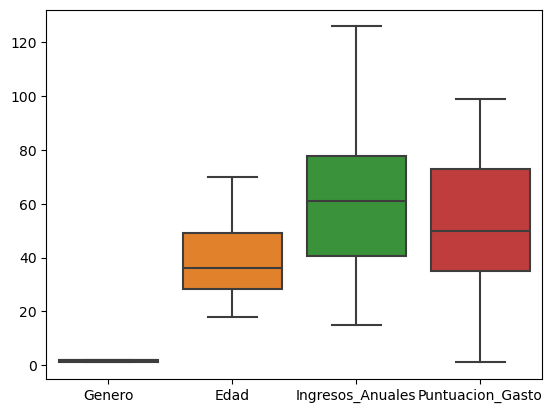

In [27]:
#Identificación de eliminación de valores faltantes y atípicos mediante una grafica 

# Diagramas de caja para cada variable por cliente
sns.boxplot(data=data_filtro)

### Análisis
- Como se puede apreciar en los datos y gráficas anteriores, no se encuentran datos faltantes, pero si se hace la limpieza de los valores atípicos en la columna de Ingresos_Anuales(k$).

### 3. Seleccionar las características más relevantes para entrenar el modelo utilizando selección de características.

Características de interes para el agrupamiento:

- Ingresos Anuales(k$)	
- Puntuacion Gasto (1-100)
- Edad

In [65]:
# Estandarizar los datos antes de aplicar
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(data_filtro), columns = data_filtro.columns)

### 4. Entrenar el modelo configurando los diferentes hiperparámetros.

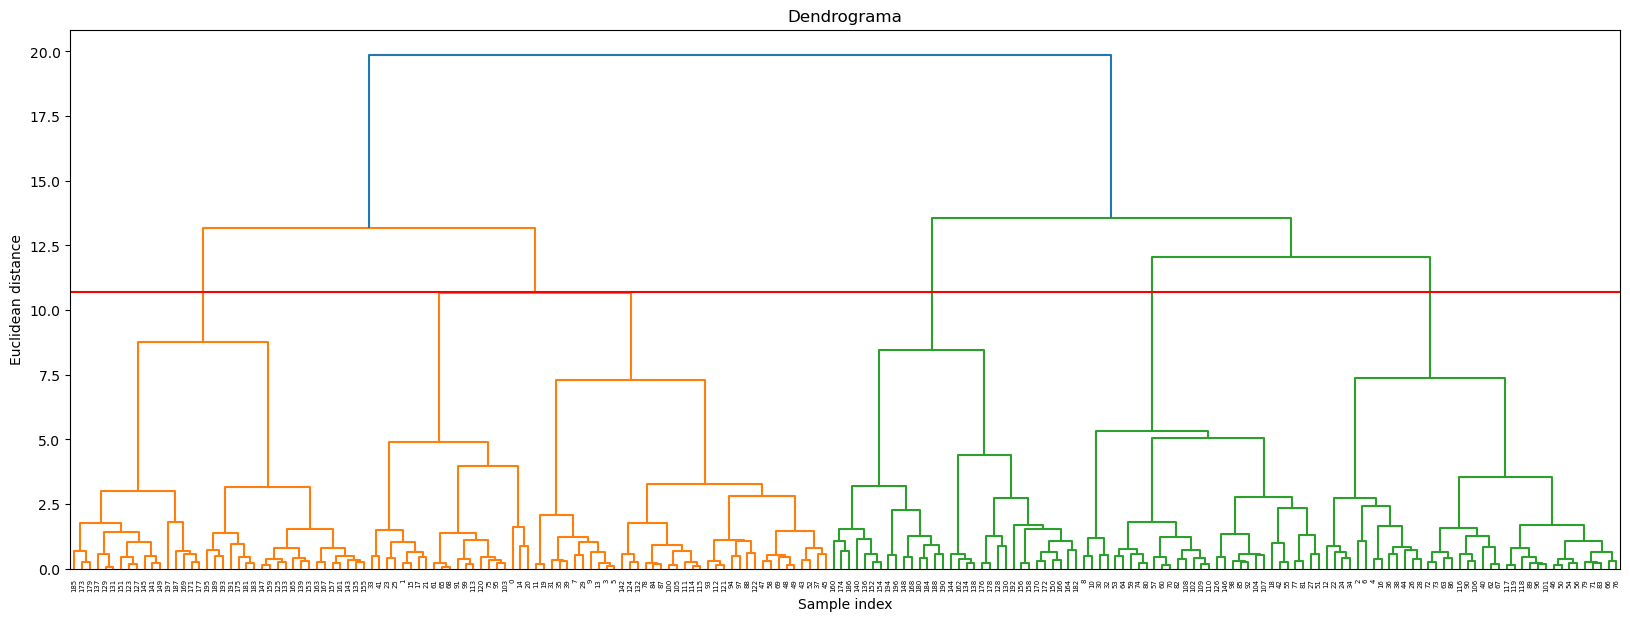

In [41]:
ward_clustering = linkage(X, method="ward", metric="euclidean")
plt.figure(figsize=(20, 7))
dendrogram(ward_clustering)
plt.axhline(y = 10.7, color = 'r', linestyle = '-')
plt.title('Dendrograma')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')
plt.show()

### Análisis
- En el dendograma sobre el eje vertical se representa la distancia de similitud entre el conjunto de los clientes de centros comerciales. A medida que crece jerárquicamente, la distancia entre estos conjuntos se hace mayor. Como las distancias no son tan considerables, se puede deducir que hay mayor similitud entre los datos.
- En el eje horizontal  se puede apreciar los grupos formados. A medida que avanza hacia la derecha, los clientes individuales se agrupan en grupos más grandes.
- Se traza una línea horizontal en el dendrograma para seleccionar el número de grupos, en este caso sorresponde a 10.7, con el fin de determinar el número de clusters, siendo estos conformados por 5.

In [114]:
#Modelo aglomerativo con los clusters identificados.
hier_clustering = AgglomerativeClustering(n_clusters=5)
labels_hier = hier_clustering.fit_predict(X)
labels_hier

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 0, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1,
       0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1],
      dtype=int64)

### 5. Evaluar el desempeño del modelo con métricas como Coeficiente de Silhouette, Índice de Calinski-Harabasz, etc.

In [66]:
# Calcular medidas de calidad para Clustering Jerárquico
print("\nMedidas de calidad para Clustering Jerárquico:")
print("Puntaje de silueta:", metrics.silhouette_score(X, labels_hier))
print("Índice de Calinski-Harabasz:", metrics.calinski_harabasz_score(X, labels_hier))
print("Davies-Bouldin Index:", metrics.davies_bouldin_score(X, labels_hier))


Medidas de calidad para Clustering Jerárquico:
Puntaje de silueta: 0.30085595511108826
Índice de Calinski-Harabasz: 80.45318572476442
Davies-Bouldin Index: 1.3867980873344916


### Análisis
- El puntaje de silueta es de aproximadamente 0.3, lo que indica que la calidad de los clústeres es moderada, pero hay espacio para mejorar.
- Índice de Calinski-Harabasz es de 80.45, el cual sugiere una calidad de agrupamiento aceptable, pero no es excepcionalmente alto. Esto podría indicar que los clústeres están moderadamente bien definidos.
- En el índice de Davies-Bouldin de 1.39 sugiere que los clústeres están razonablemente separados, aunque no de manera óptima.

In [67]:
# Calcular el coeficiente de correlación cofenética
from scipy.cluster.hierarchy import linkage
# Compute the distances
X_dist = pdist(X)
# Compute the linkage matrix
Z = linkage(X, 'ward')
# Calculate the cophenetic correlation coefficient
coef_cofenetico = cophenet(Z, X_dist)
print("Coeficiente de correlación cofenética:", coef_cofenetico)

Coeficiente de correlación cofenética: (0.7241042397099979, array([ 4.7155927 , 26.88639278, 15.21583715, ..., 26.88639278,
       15.21583715, 26.88639278]))


### Análisis
El coeficiente de correlación cofenética es de aproximadamente 0.72, lo cual es un valor moderadamente alto. Esto indica que el clustering jerárquico representa de manera razonable las distancias originales entre los datos.

### 6. Realizar las diferentes gráficas que permitan visualizar los resultados del modelo

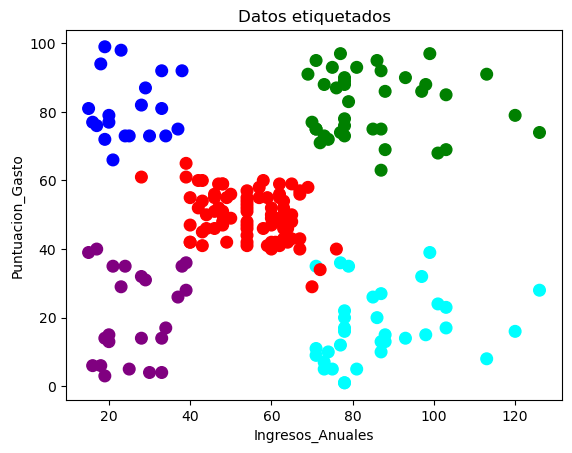

In [124]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = labels_hier
colores = ['red', 'green', 'cyan', 'blue', 'purple']  # Definir colores adicionales
asignar = []

# Modificar el ciclo para cinco clusters
for row in labels:
    asignar.append(colores[row])

# Suponiendo que 'X' es un DataFrame de pandas
f1 = X['Ingresos_Anuales'].values
f2 = X['Puntuacion_Gasto'].values
plt.scatter(f1, f2, c=asignar, s=70)
plt.title('Datos etiquetados')
plt.xlabel('Ingresos_Anuales')
plt.ylabel('Puntuacion_Gasto')
plt.show()

### Análisis
En la gráfica de dispersión generada a partir del clustering jerárquico con 5 clusters, se observa que el algoritmo ha identificado distintos grupos basados en las características de los gastos de los clientes e ingresos anuales, se puede notar una mayor concentración de clientes con ingresos anuales entre aproximadamente 70 y 120, aunque estos están distribuidos de manera dispersa. Además, se observa una concentración más notable entre aquellos cuyos ingresos anuales oscilan entre 40 y aproximadamente 70, y que tienen una puntuación de gasto entre 40 y 65.5.

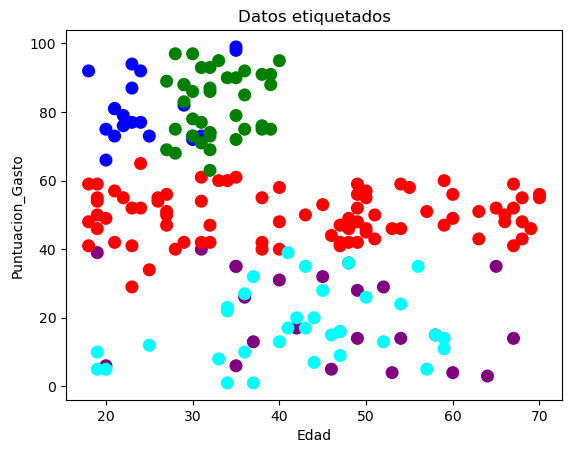

In [125]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = labels_hier
colores = ['red', 'green', 'cyan', 'blue', 'purple']  # Definir colores adicionales
asignar = []

# Modificar el ciclo para cinco clusters
for row in labels:
    asignar.append(colores[row])

# Suponiendo que 'X' es un DataFrame de pandas
f1 = X['Edad'].values
f2 = X['Puntuacion_Gasto'].values
plt.scatter(f1, f2, c=asignar, s=70)
plt.title('Datos etiquetados')
plt.xlabel('Edad')
plt.ylabel('Puntuacion_Gasto')
plt.show()

### Análisis
En la gráfica de dispersión de la edad y puntuación de gastos prresenta puntos de un grupo diferente, esto puede deberse a la superposición de clusters, ubicación en los bordes de clusters, errores de clasificación o la complejidad inherente de los datos. En el grupo rojo se presenta en la mayoria de la edad del conjunto de datos con una puntuación especialmente entre 40 y 60.

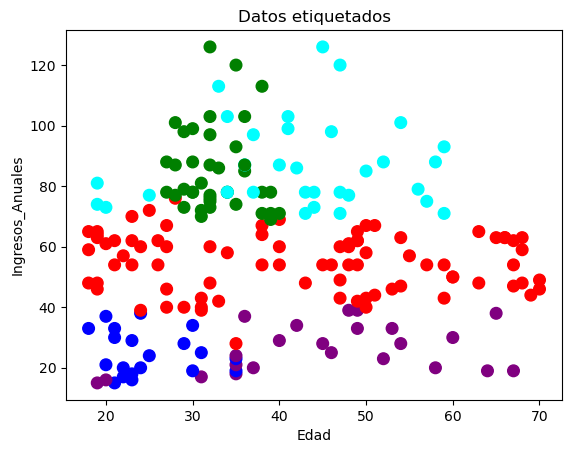

In [126]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = labels_hier
colores = ['red', 'green', 'cyan', 'blue', 'purple']  # Definir colores adicionales
asignar = []

# Modificar el ciclo para cinco clusters
for row in labels:
    asignar.append(colores[row])

# Suponiendo que 'X' es un DataFrame de pandas
f1 = X['Edad'].values
f2 = X['Ingresos_Anuales'].values
plt.scatter(f1, f2, c=asignar, s=70)
plt.title('Datos etiquetados')
plt.xlabel('Edad')
plt.ylabel('Ingresos_Anuales')
plt.show()

### Análisis
En esta última gráfica que muestra la relación entre los ingresos anuales y la edad de los clientes, también es importante destacar la presencia de una mezcla entre los puntos de diferentes clusters. Los puntos rojos y morados se presentan en casi todas las edaddes, mientras que el cluster verde y azul son más pequeños y se encuentran en el rango de 19 a 40 años. Evidenciando que especialmente las personas jovenes son las que presentan menor ingreso anual.. 

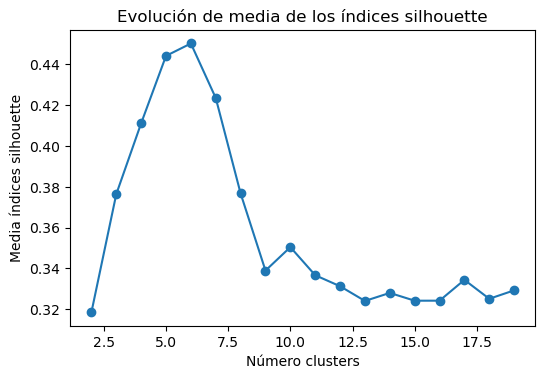

In [113]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 20)
valores_medios_silhouette = []
for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
                    affinity   = 'euclidean',
                    linkage    = 'ward',
                    n_clusters = n_clusters
             )
    cluster_labels = modelo.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

### Análisis
En la evolución de media de los índices silhouette se identifica el número óptimo de clusters en el conjunto de datos para la aplicación del algoritmo de clustering, en este caso considero que debiese ser 5 o un número menor. Este Proporciona una medida de cuán similar es un punto a su propio cluster en comparación con otros clusters. 

### 7. Interpretar, análisis, documentar los resultados obtenidos y conclusión

- La diferencia en la puntuación de gasto entre mujeres y hombres es mínima, lo que sugiere que se tiene un comportamiento de compra similar a la vida real.
- El modelo de clustering jerárquico nos permitio visualizar la estructura de agrupamiento de los datos de una manera jerárquica, lo que significa la visualización de los puntos de datos agrupados a diferentes niveles de similitud. Esto proporciona una visión detallada de cómo los datos están organizados y cómo se relacionan entre sí.
- Se evidencio un mejor agrupamiento en el conjunto de datos entre los Ingresos Anuales y Puntuacion de Gasto.
- Cuando los puntos están muy dispersos dentro de los clusters, es importante considerar la diversidad en el comportamiento de los datos, la ambigüedad en la definición de clusters, limitaciones del algoritmo de clustering y la necesidad de ajustar parámetros para mejorar la calidad de los clusters. Esto puede requerir un análisis más detallado y la exploración de diferentes enfoques de clustering para obtener resultados más significativos y útiles.
- Aunque el modelo de clustering jerárquico ha producido resultados moderadamente satisfactorios, aún hay aspectos que podrían mejorarse para lograr una agrupación más clara y precisa de los datos.